Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
airbnb <- read.csv('airbnb-listings.csv',sep = ';', stringsAsFactors = T)
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
airbnb <- airbnb[ , c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms', 'Bedrooms',
                      'Beds', 'Price', 'Square.Feet', 'Guests.Included','Extra.People',
                      'Review.Scores.Rating','Latitude', 'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
df <- airbnb[airbnb$City == 'Madrid', ]
df_madrid <- df[df$Room.Type == 'Entire home/apt', ]
df_madrid <- df[df$Neighbourhood != '', ]

In [4]:
df_madrid <- df_madrid[-c(1, 2)]

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [5]:
df_madrid$Square.Meters = df_madrid$Square.Feet * 0.092903

In [6]:
# Drop Square.Feets
df_madrid <- df_madrid[-c(7)]

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [7]:
sm_na <- sum(is.na(df_madrid$Square.Meters))

In [8]:
percentage_na <- sm_na / nrow(df_madrid) * 100
percentage_na 

[1] 94.26482

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [9]:
table(df_madrid[df_madrid$Square.Meters == 0, 'Square.Meters'])


  0 
199 

In [10]:
not_na <- nrow(df_madrid) - sm_na
not_zero <- not_na - 199

In [11]:
percentage_zero <- 199 / not_zero * 100
percentage_zero

[1] 65.67657

Reemplazar todos los 0m^2 por NA 

In [12]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más, además crearemos una variable sintética nueva basada en la similitud entre barrios.

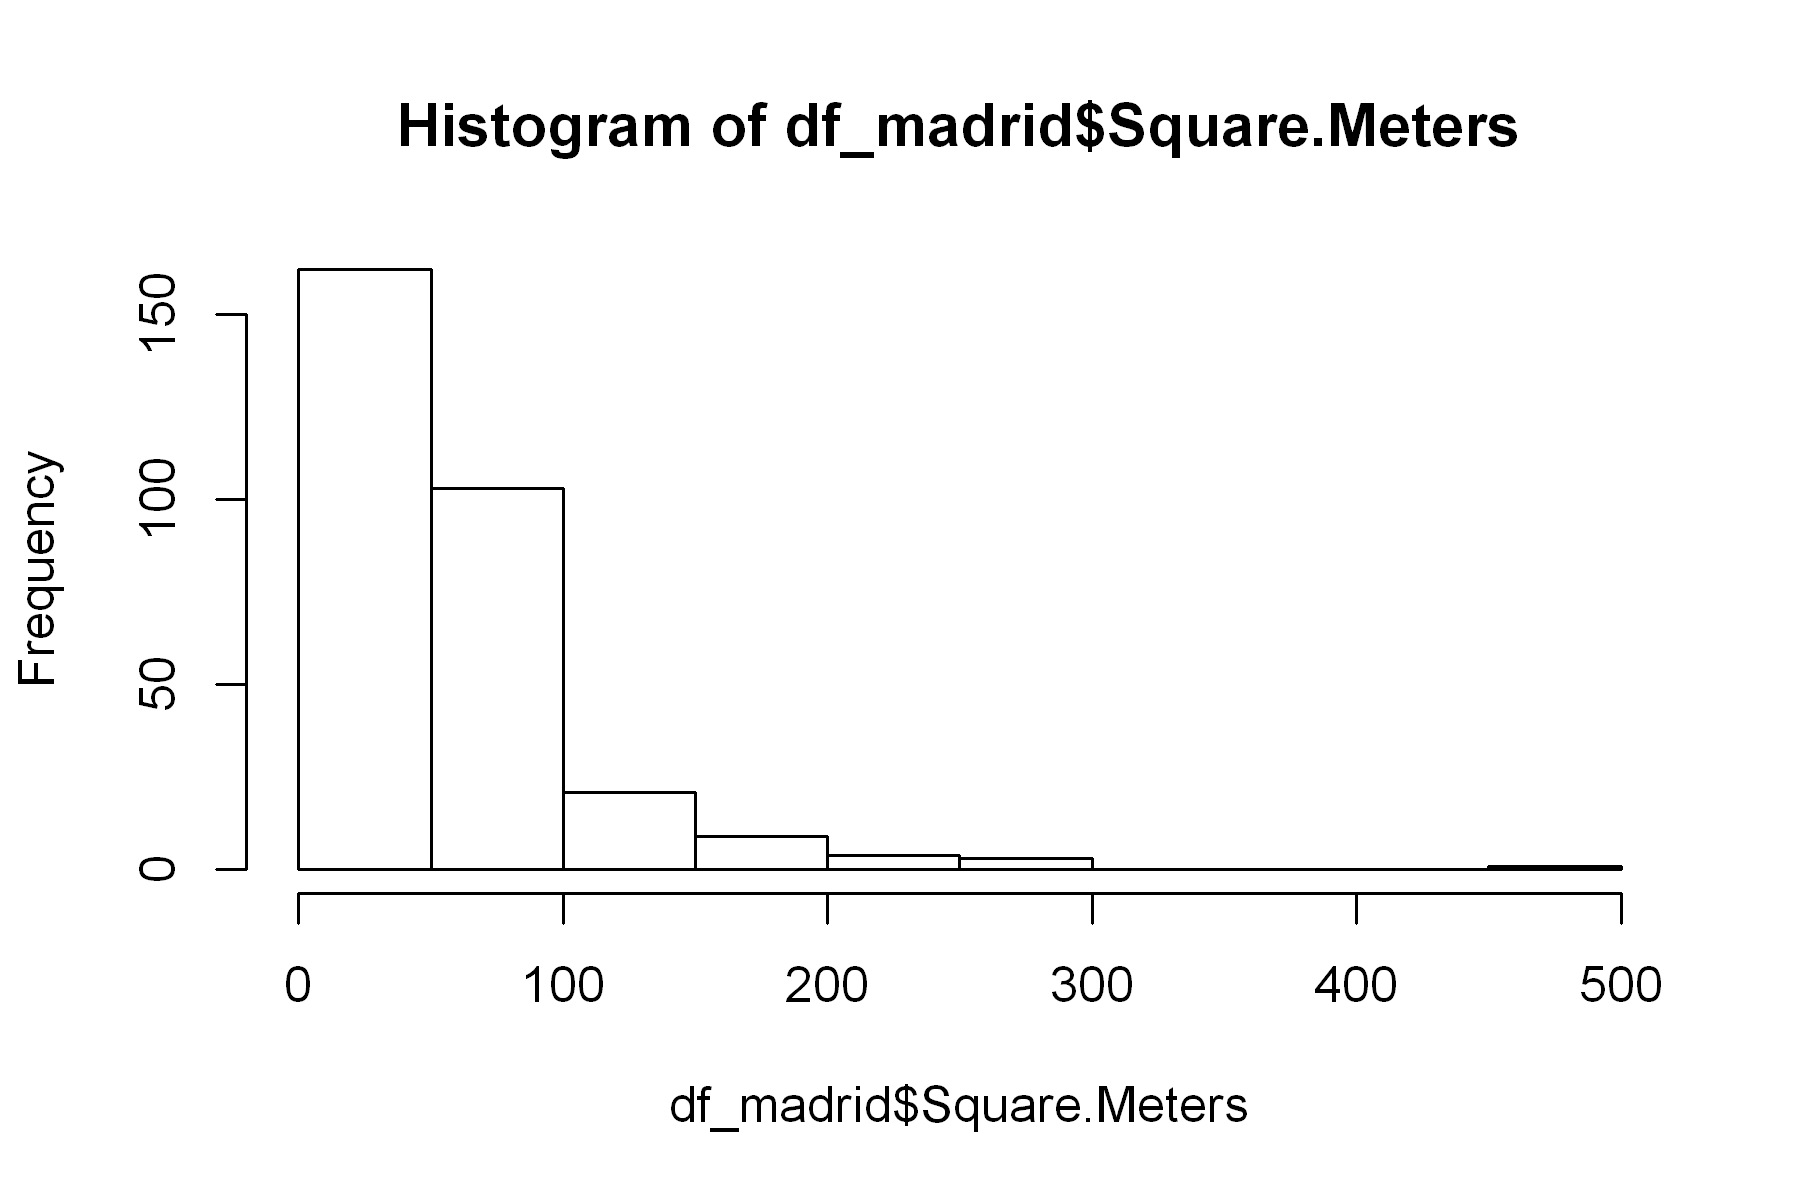

In [13]:
hist(df_madrid$Square.Meters)

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [14]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas de Square Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [15]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [16]:
# Agrupamos por barrio y sumamos los metros cuadrados
df_grouped <- df_madrid %>% group_by(Neighbourhood) %>% summarise_at(vars(Square.Meters),funs(sum(.,na.rm=TRUE)))
# Creamos un dataframe todos aquellos cuya suma haya dado 0
df_zeros <- df_grouped[df_grouped$Square.Meters == 0, 'Neighbourhood']
# Quitamos todos los barrios que salgan en el anterior dataframe 
df_madrid <- df_madrid[!df_madrid$Neighbourhood %in% df_zeros$Neighbourhood,]

Warning message:
"`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"

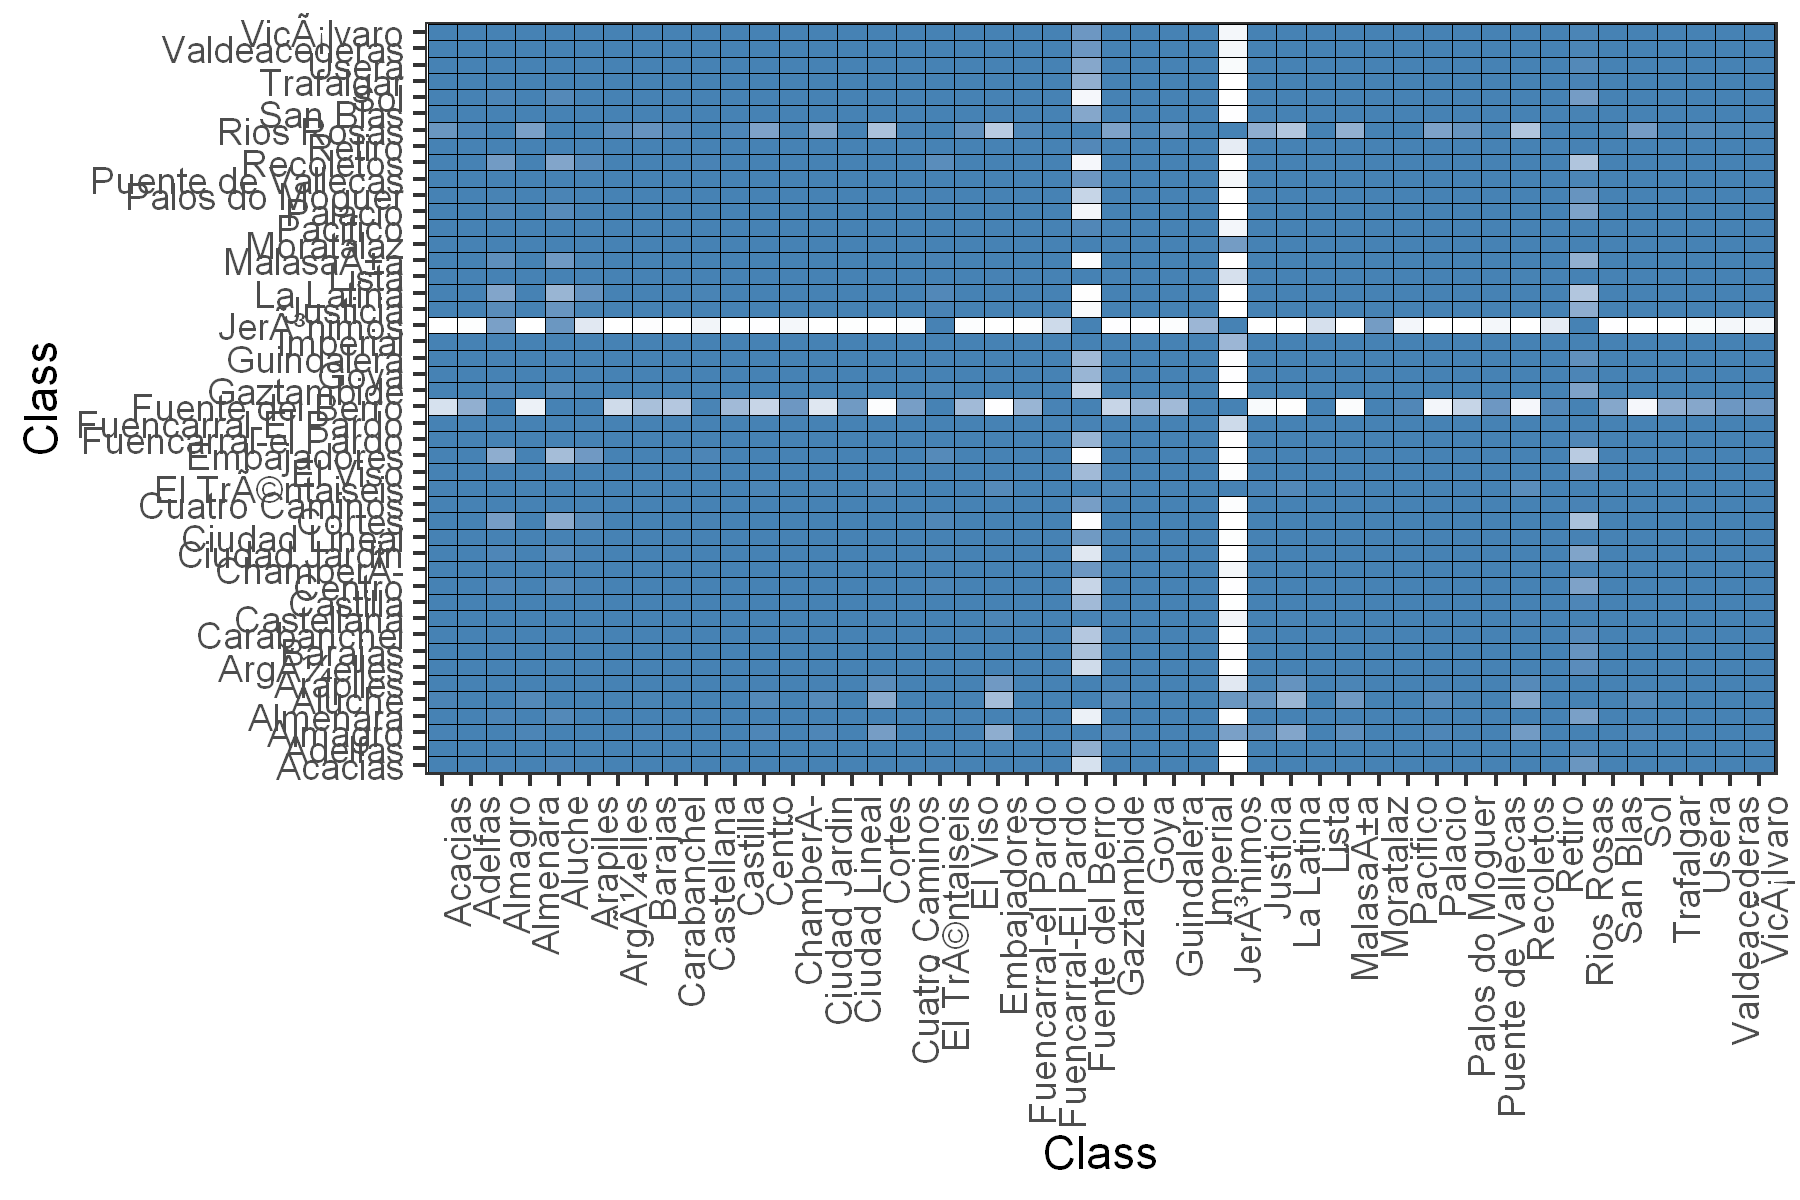

In [17]:
tky <- TukeyHSD(aov(formula = Square.Meters ~ Neighbourhood, data = df_madrid))
tky.result <- data.frame(tky$Neighbourhood)
cn <- sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj, 4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(colour = "black") +
  scale_fill_gradient(low = "white",high = "steelblue") +
  ylab("Class") + xlab("Class") + theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


Warning message:
"package 'dendextend' was built under R version 3.6.3"
---------------------
Welcome to dendextend version 1.14.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: 'dendextend'

The following object is masked from 'package:stats':

    cutree



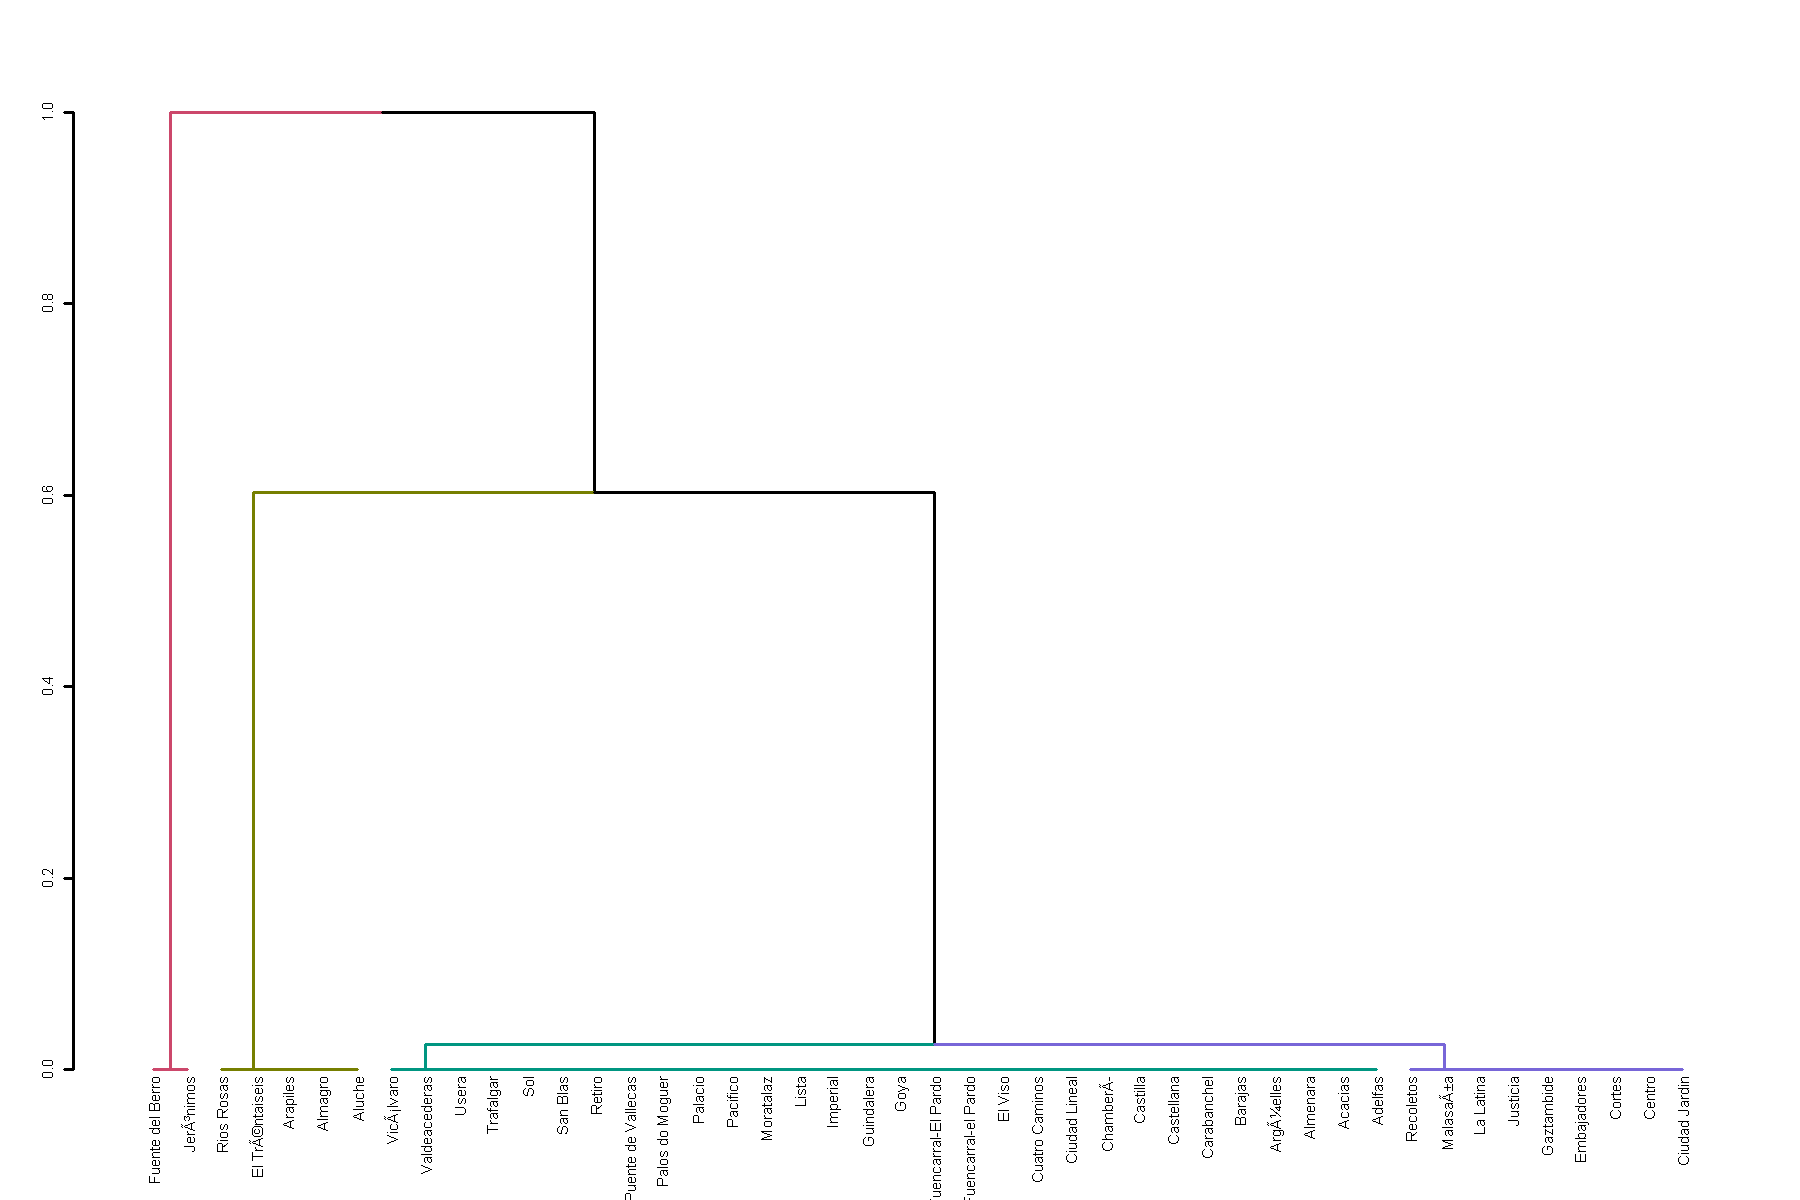

In [18]:
library('dendextend')
d <- as.dist(1 - resm)
hc <- hclust(d ,method = "complete")
hcd <- as.dendrogram(hc)
par(cex=0.3)
plot(color_branches(hcd, k = 4))

¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

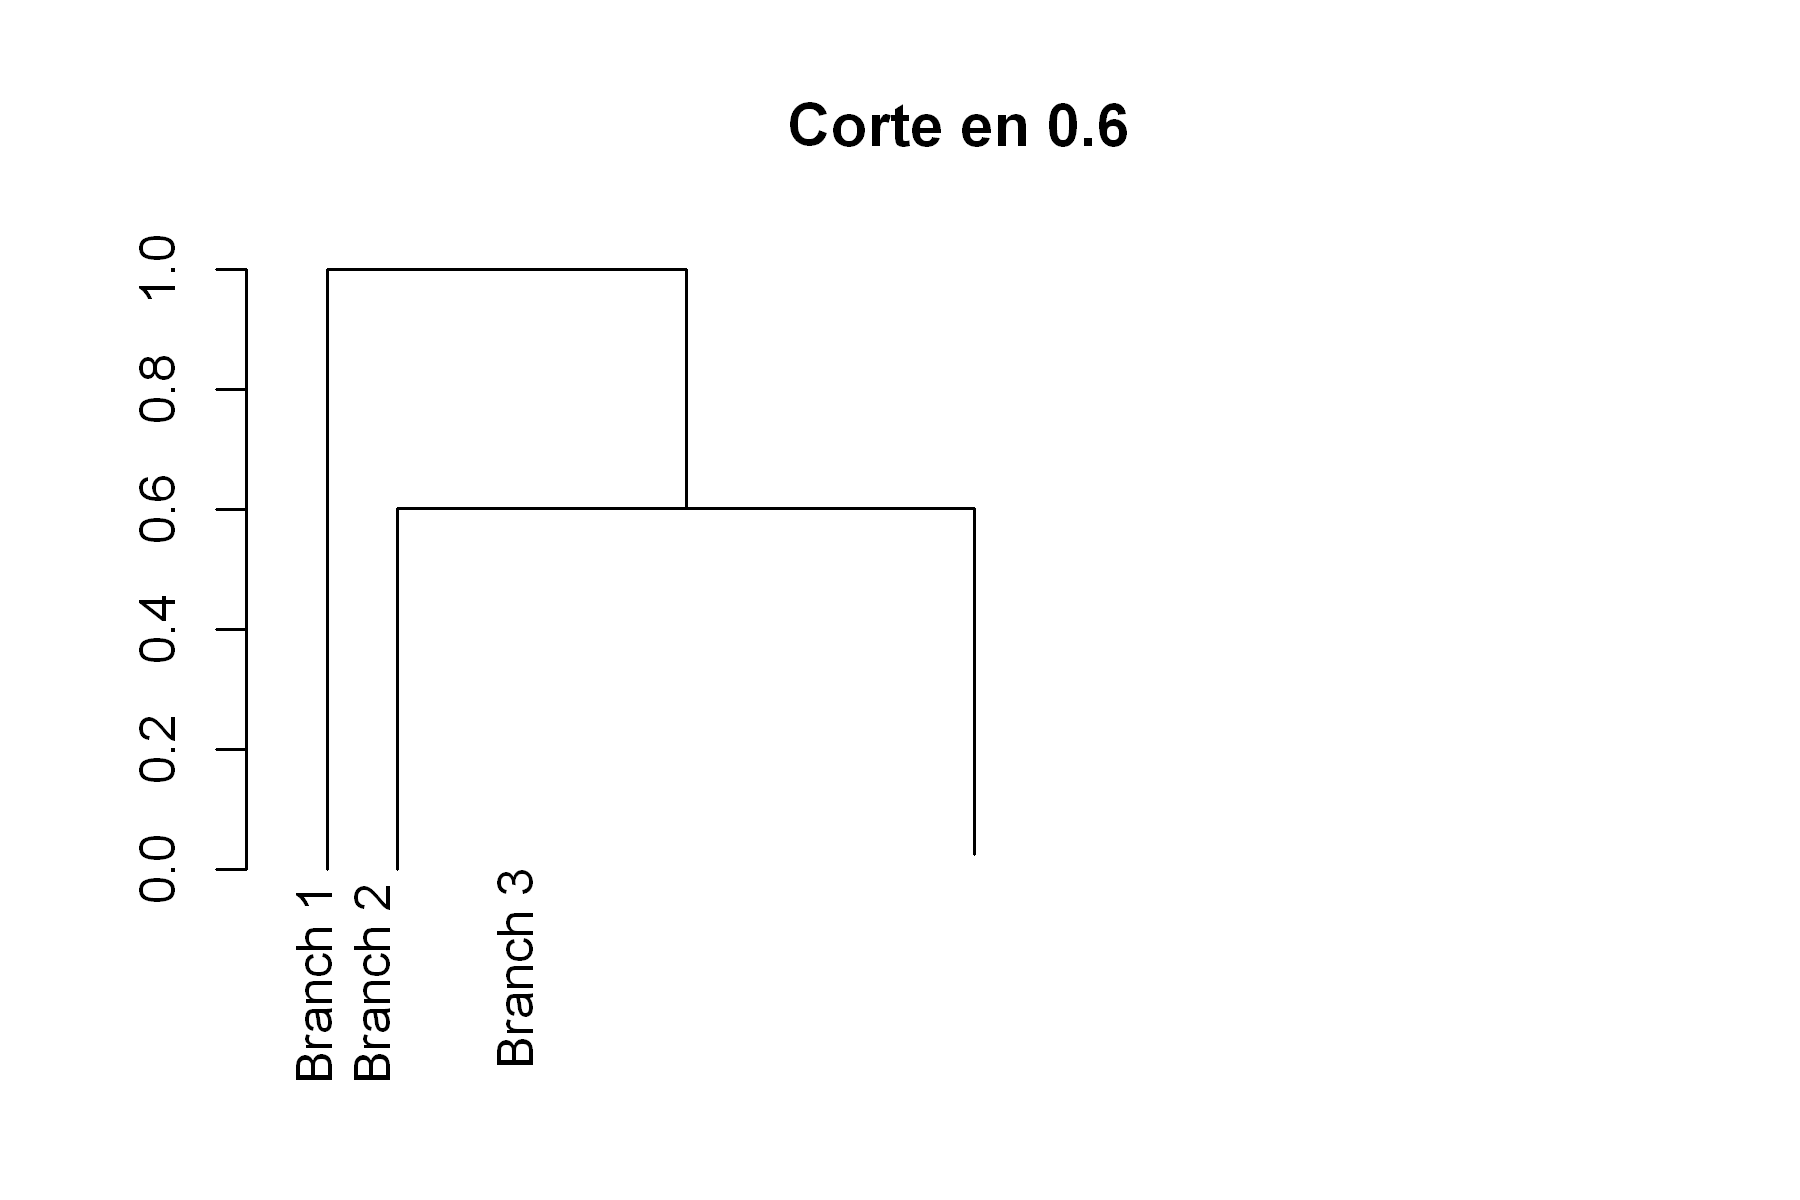

In [19]:
plot(cut(hcd, h = 0.6)$upper, main = "Corte en 0.6", cex = 1)

0.6 sería un buen punto de corte. Habría tres clusters

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [20]:
cl <- cutree_1h.dendrogram(hcd, h = 0.6)

In [21]:
df_cl <- as.data.frame(cl)
df_cl <- cbind(Neighbourhood = rownames(df_cl), df_cl)
rownames(df_cl) <- NULL
colnames(df_cl)[2] <- "neighb_id"
df_madrid <- merge(df_madrid, df_cl, by = "Neighbourhood")
df_madrid$neighb_id <- factor(df_madrid$neighb_id)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [22]:
library(tidyverse)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.6     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [23]:
# Ahora que tenemos los clusters, quitamos Neighbourhood
df_madrid <- df_madrid[c(-1)]

In [24]:
library(caret)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"
Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [25]:
set.seed(17)
idx <- sample(1:nrow(df_madrid), nrow(df_madrid) * 0.7)
df_madrid.train <- df_madrid[idx,]
df_madrid.test <- df_madrid[-idx,]

In [26]:
df_madrid_train_norm <- df_madrid.train
df_madrid_test_norm <- df_madrid.test

df_madrid_train_norm$Square.Meters <- NULL
df_madrid_test_norm$Square.Meters <- NULL

norm_param <- preProcess(df_madrid_train_norm)
df_madrid_train_norm <- predict(norm_param, df_madrid_train_norm)
df_madrid_test_norm <- predict(norm_param, df_madrid_test_norm)

df_madrid_train_norm$Square.Meters <- df_madrid.train$Square.Meters
df_madrid_test_norm$Square.Meters <- df_madrid.test$Square.Meters

In [27]:
# # Dummy encoding
# df_madrid_norm <- df_madrid_norm %>% 
#   mutate(Neighbourhood = paste("neighbourhood", Neighbourhood, sep = "_"),
#          valor_neighbourhood = 1
#          ) %>% 
#   spread(key = Neighbourhood, value = valor_neighbourhood, fill = 0)

In [28]:
model <- lm(Square.Meters ~ .-Latitude-Longitude-Review.Scores.Rating-Guests.Included-Beds, data = df_madrid_train_norm)
summary(model)


Call:
lm(formula = Square.Meters ~ . - Latitude - Longitude - Review.Scores.Rating - 
    Guests.Included - Beds, data = df_madrid_train_norm)

Residuals:
     Min       1Q   Median       3Q      Max 
-103.465  -15.963   -0.629   12.076  113.647 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    63.836      3.189  20.018  < 2e-16 ***
Accommodates   -3.186      4.555  -0.699  0.48561    
Bathrooms      17.253      4.091   4.217 4.76e-05 ***
Bedrooms       11.546      3.522   3.278  0.00136 ** 
Price           2.961      2.257   1.312  0.19198    
Extra.People    7.354      3.372   2.181  0.03108 *  
neighb_id2     59.018     13.005   4.538 1.33e-05 ***
neighb_id3    145.848     24.778   5.886 3.51e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 30.96 on 123 degrees of freedom
  (5443 observations deleted due to missingness)
Multiple R-squared:  0.6684,	Adjusted R-squared:  0.6495 
F-statistic: 35.42 

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

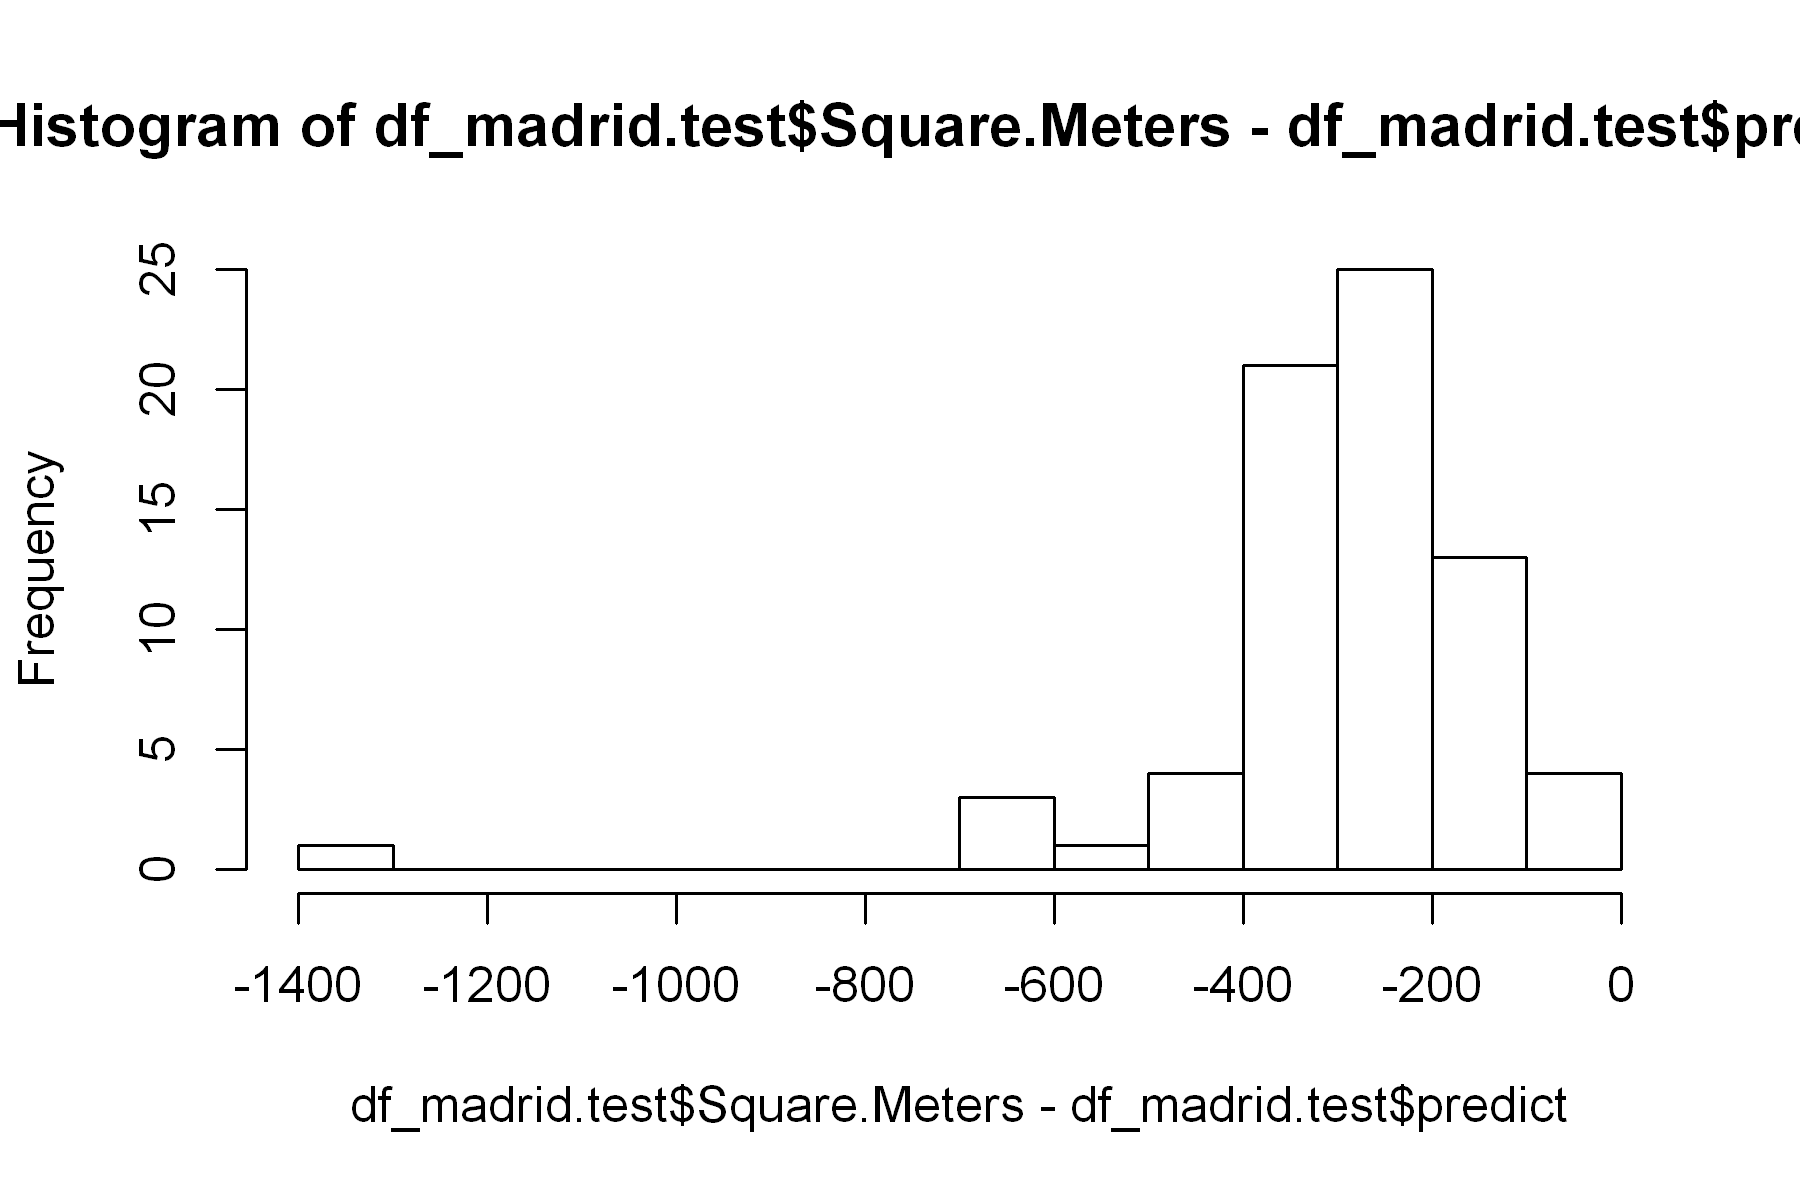

In [29]:
df_madrid.test$predict <- predict(model, df_madrid.test)
hist(df_madrid.test$Square.Meters - df_madrid.test$predict, 10)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [30]:
# Intercept + neigh_id == 3 + Accommodates * 6 + Price * 80 + Bederooms * 3
print(63.836 + 145.848 + (-3.186) * 6 + 2.961 * 80 + 17.253 * 3)
print('Por cada habitación adicional, los metros cuadrados aumentan 17.253')

[1] 479.207
[1] "Por cada habitación adicional, los metros cuadrados aumentan 17.253"


Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [31]:
df_madrid_na <- df_madrid[is.na(df_madrid$Square.Meters),]
df_madrid_na_norm <- predict(norm_param, df_madrid_na)

In [32]:
df_madrid_na_norm$Square.Meters <- predict(model, df_madrid_na_norm)

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [33]:
df_madrid_pca <- df_madrid_na_norm[c(-12)]

idx <- sample(1:nrow(df_madrid_pca), nrow(df_madrid_pca) * 0.7)
df_madrid_pca.train <- df_madrid_pca[idx,]
df_madrid_pca.test <- df_madrid_pca[-idx,]

In [34]:
pca <- prcomp(na.omit(df_madrid_pca.train), center = TRUE, scale = TRUE)

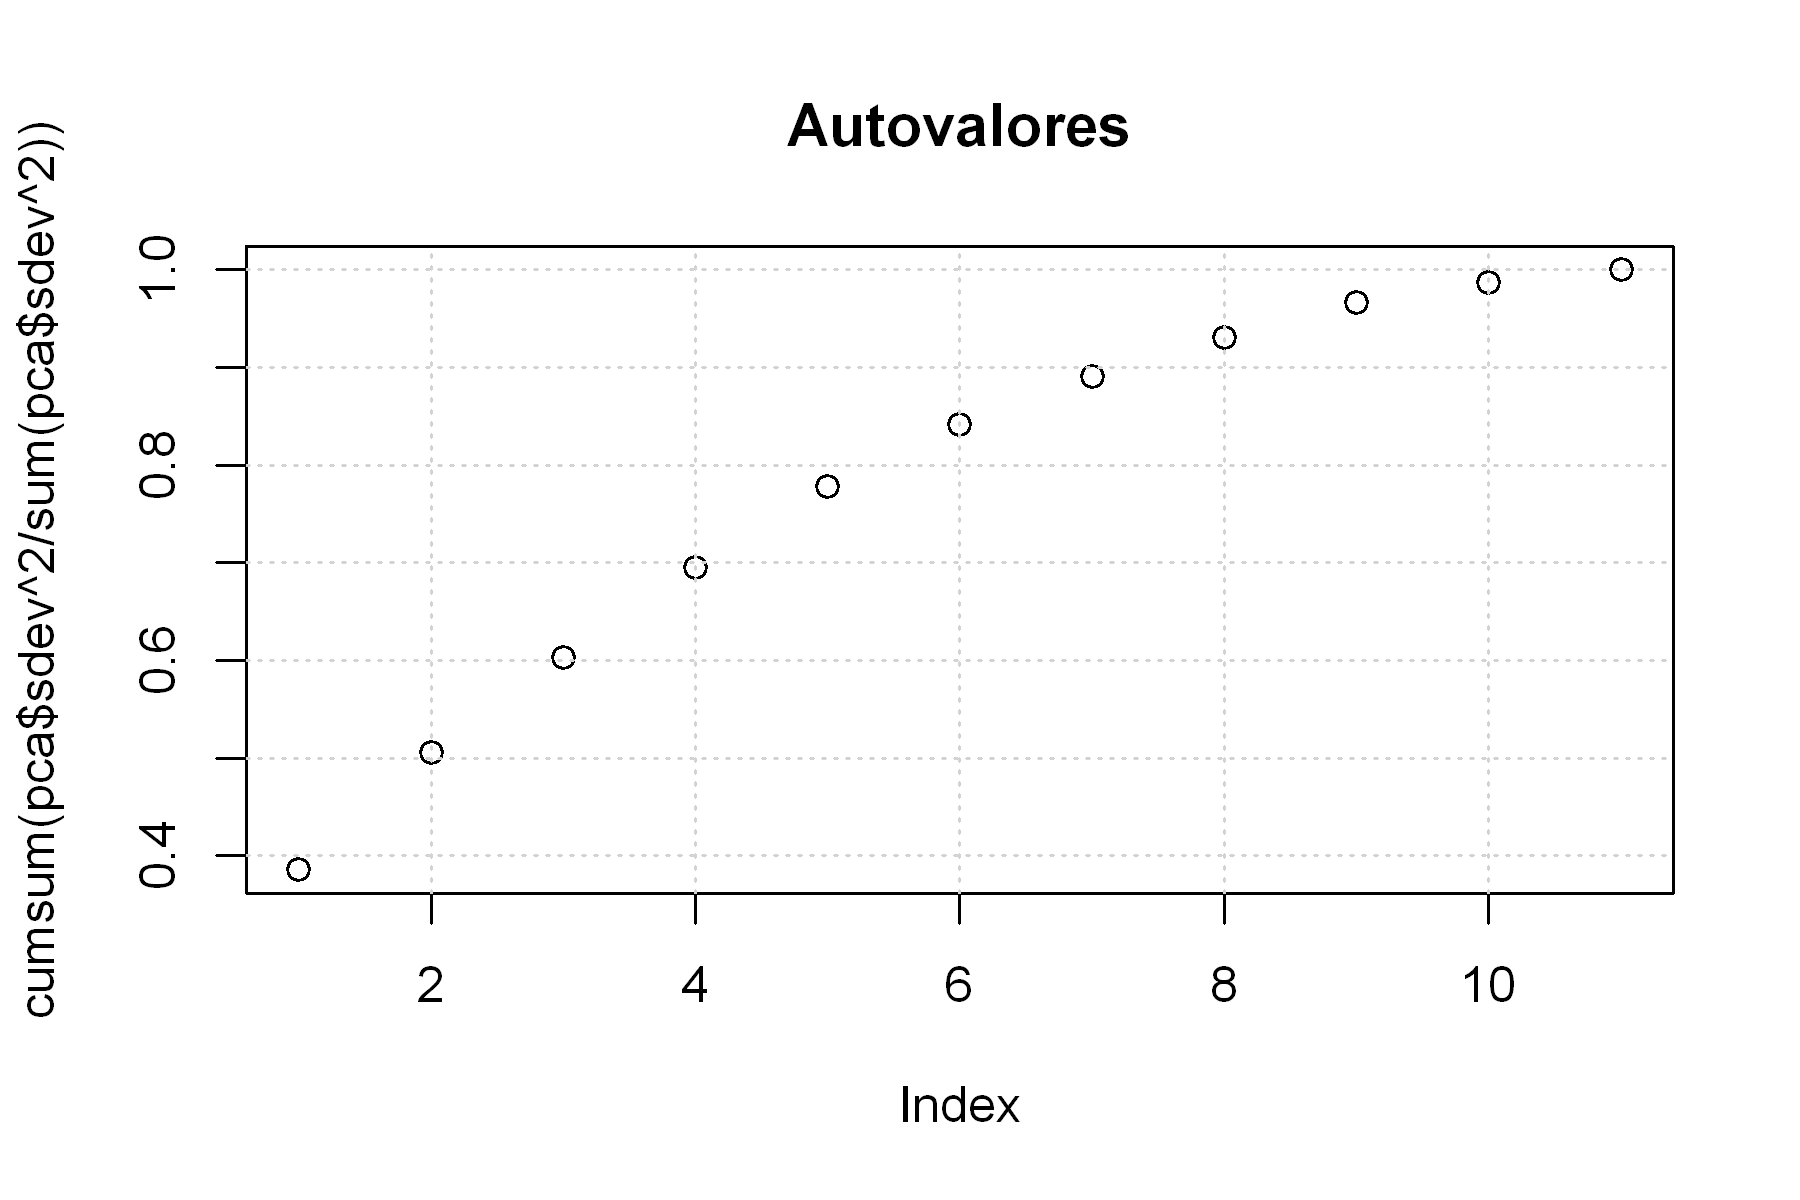

In [35]:
plot(cumsum(pca$sdev^2/sum(pca$sdev^2)), main="Autovalores")
grid()

In [36]:
piso_pca <- predict(pca, na.omit(df_madrid_pca.test))

In [37]:
top5 <- function(df, number_of_pca_components, id_test) {
    test_selected <- df[id_test,]
    test <- matrix(test_selected[1:number_of_pca_components], nrow = 1)
    Apc <- pca$x[, 1:number_of_pca_components]
    dist <- rep(NA, nrow(Apc))
    for (i in 1:nrow(Apc)){
        dist[i] <- sum((test - Apc[i,])^2)
    }
    # Asignamos a cada valor un índice
    index <- 1:length(dist)
    # Recuperamos esos índices en una lista ordenada
    sorted_index <- index[order(dist)]
    # Mostramos los 5 primeros
    top5 <- head(sorted_index, 5)
      
    return(top5)
}

In [38]:
id_test = 42
most_sim <- top5(df = piso_pca, 6, id_test)

In [39]:
df_madrid_pca.test[id_test,]

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
166,-0.6620761,-0.440662,-1.540422,-0.6862762,-0.4742481,-0.5831361,-0.7109047,-0.04540476,0.8294415,0.06152546,92.94218


In [40]:
df_madrid_pca.train[c(most_sim),]

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
7588,-0.1612058,-0.4406620,-0.3503193,-0.03235487,-0.2617880,1.1911001,0.2050241,0.1755177,-0.3016234,-0.4254848,53.43466
3238,-0.1612058,-0.4406620,0.8397831,-0.03235487,-0.4388381,0.3039820,0.9377671,0.3964401,0.5266958,1.1470898,72.03990
7899,-1.1629465,-0.4406620,-0.3503193,-0.68627616,-0.8283483,-0.5831361,-0.7109047,0.6173626,-2.4467911,-0.0133906,48.21231
2650,-0.6620761,-0.4406620,-1.5404217,-0.68627616,0.1808372,-0.5831361,-0.7109047,0.3964401,-0.3902145,-0.3876165,35.86412
7695,2.8440160,0.3463458,4.4100904,1.92940902,0.1454272,-0.5831361,-0.7109047,NA,0.6427216,-0.2335933,106.87189


In [41]:
paste('Las imágenes más parecidas a la número:', id_test, 'son:', most_sim[1], most_sim[2],
          most_sim[3], most_sim[4], most_sim[5])

[1] "Las imágenes más parecidas a la número: 42 son: 2979 3606 356 3962 3067"

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?